In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder


In [3]:
import pre_organize_xuwen as po

In [6]:
dimension = 32
batch_size = 32
skip_size = 8
skip_window = 1
num_skips = 2
iteration_train_vectors = 5000

num_layers = 2
size_layer = 256
learning_rate = 0.001
epoch = 10
batch = 30

In [37]:
string, data, label, vocab = po.read_data('train.csv',200)
label_encode = LabelEncoder().fit_transform(label)
dictionary, reverse_dictionary, vectors = po.generatevector(dimension, dimension, skip_size, skip_window, num_skips, iteration_train_vectors, string)

there are 200 total rows
data size:  14353
Creating Word2Vec model.


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


epoch:  1000 , loss:  24.3597 , speed:  0.0023870468139648438
epoch:  2000 , loss:  0.383856 , speed:  0.002386808395385742
epoch:  3000 , loss:  0.0209773 , speed:  0.0036039352416992188
epoch:  4000 , loss:  3.07845 , speed:  0.0022301673889160156
epoch:  5000 , loss:  0.0117801 , speed:  0.0022308826446533203


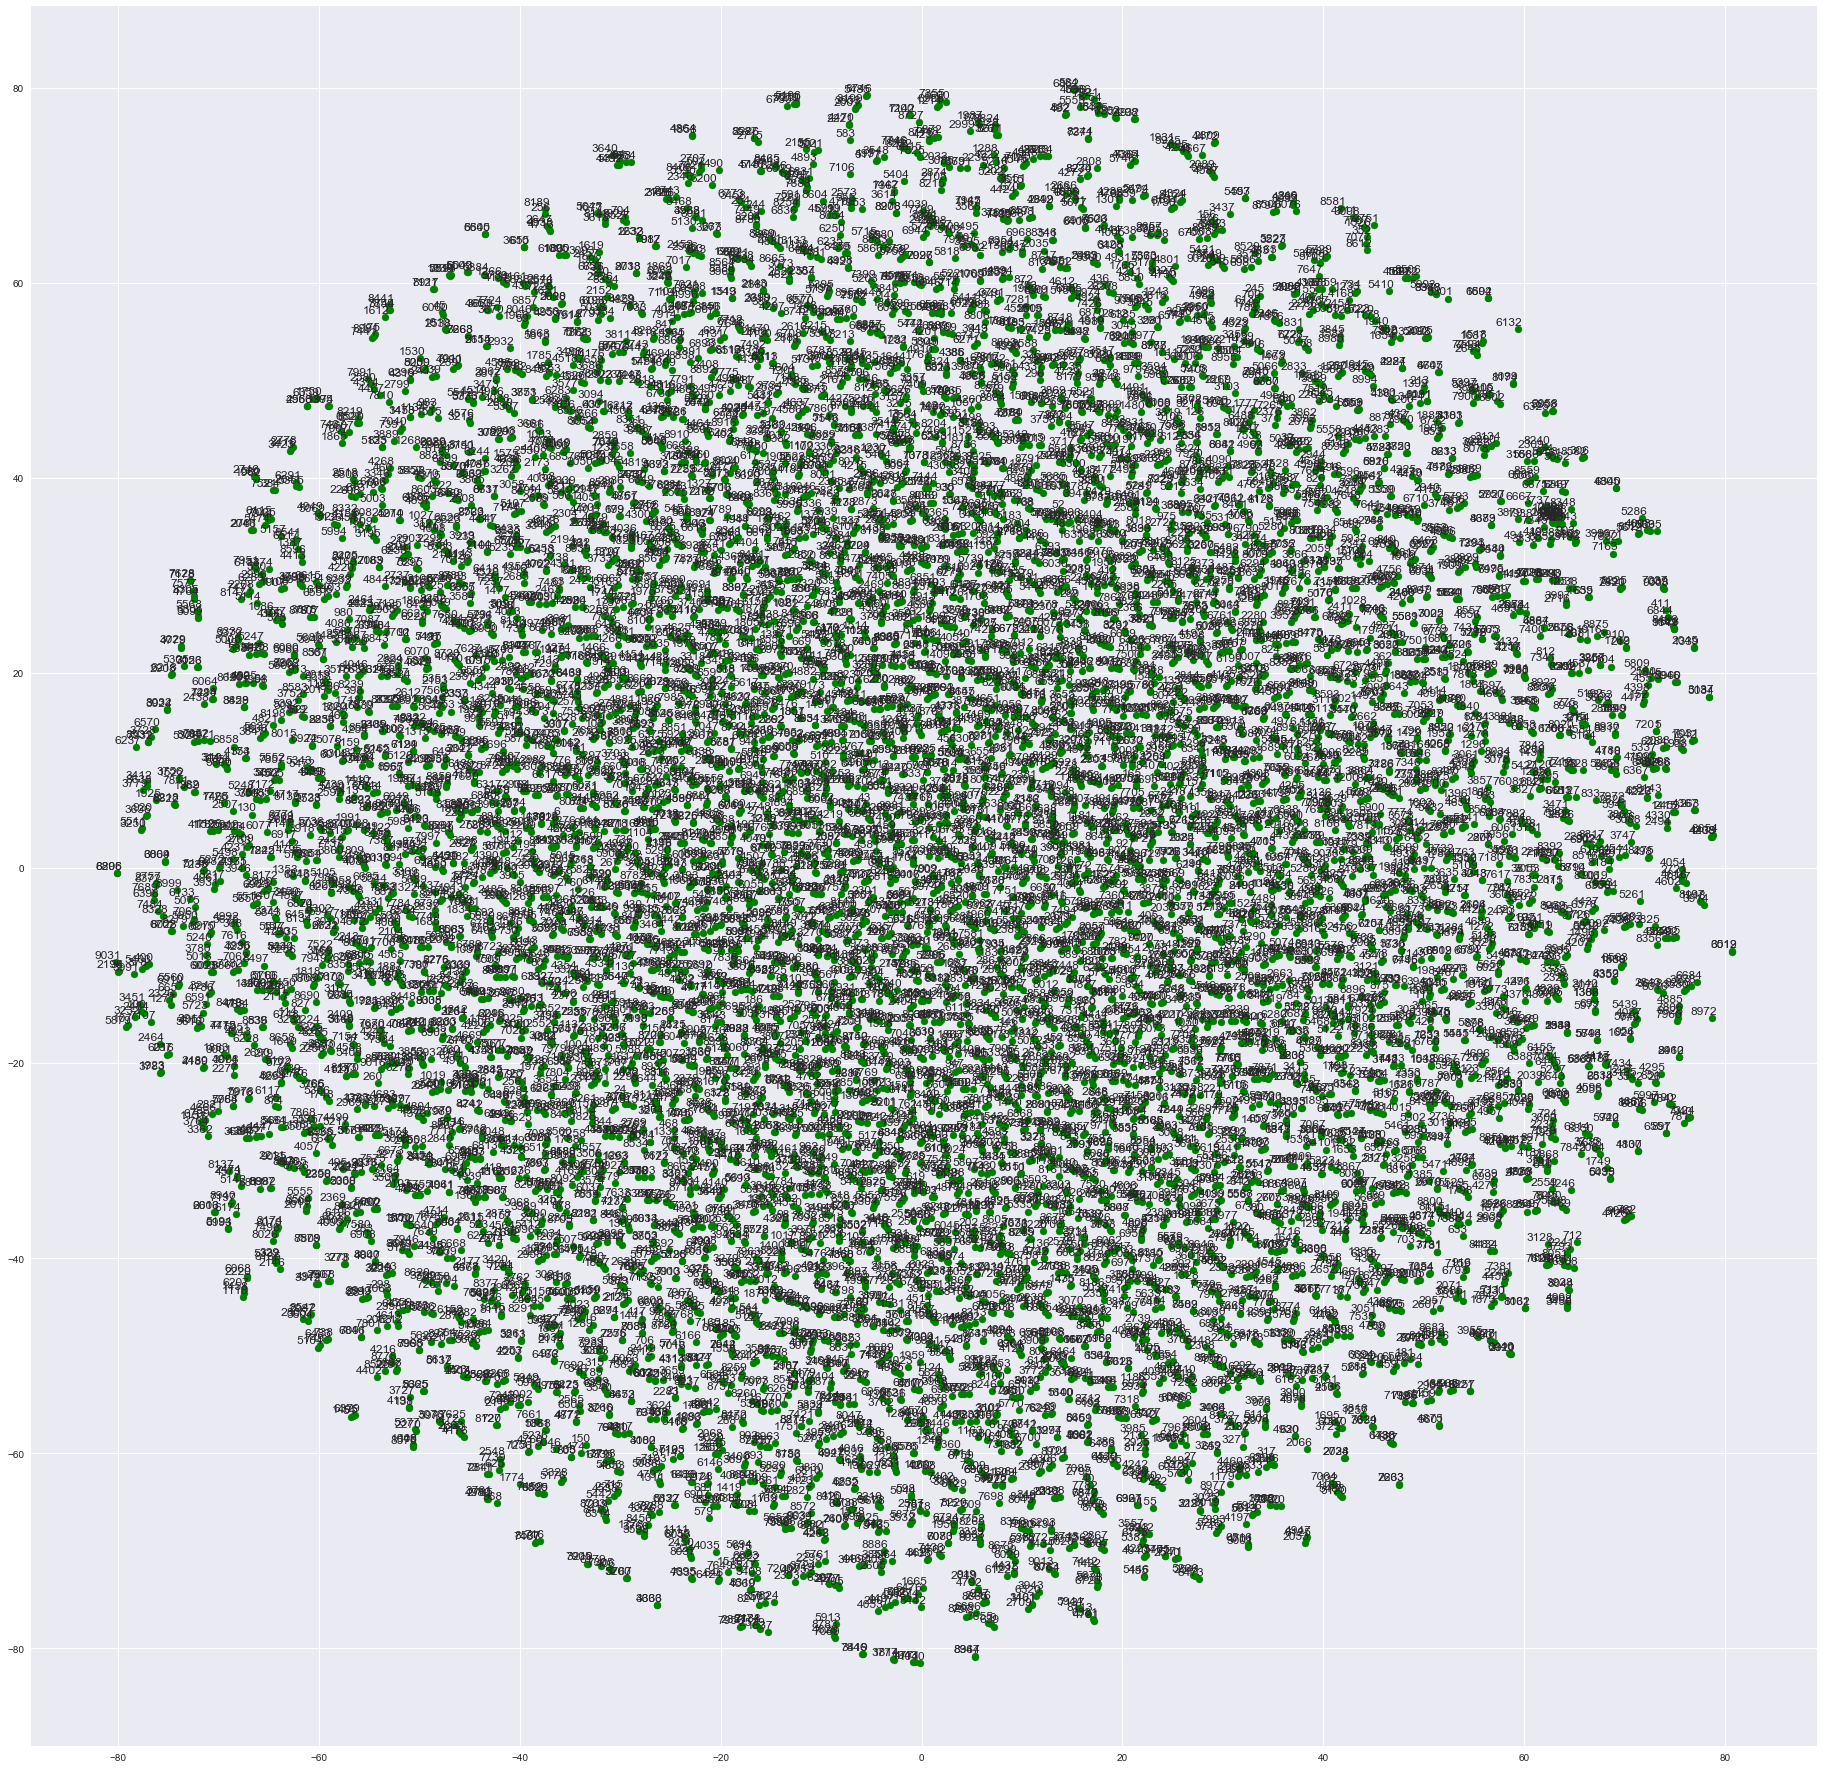

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
sns.set()

embed = TSNE(n_components = 2).fit_transform(vectors)
plt.figure(figsize = (32, 32))

for i, label in enumerate(reverse_dictionary):
    x, y = embed[i, :]
    plt.scatter(x, y, c = 'g')
    plt.annotate(label, xy = (x, y), xytext = (5, 2), textcoords = 'offset points', ha = 'right', va = 'bottom')

plt.show()


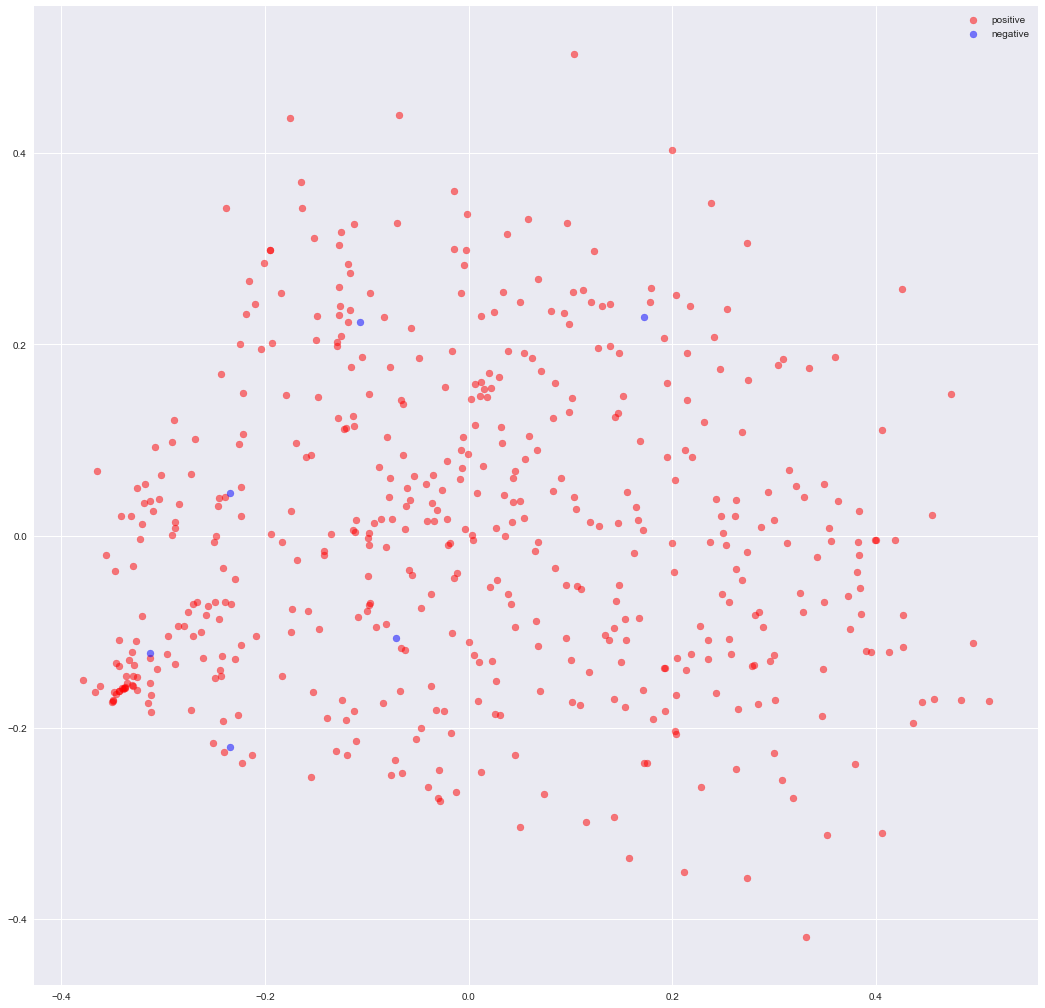

In [21]:
bagofword = np.zeros((len(data), len(vocab)))
for i in range(len(data)):
    for _, text in enumerate(data[i].split()):
        bagofword[i, vocab.index(text)] += 1.0
        
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

bagofword = Normalizer().fit_transform(bagofword)
data_visual = PCA(n_components = 2).fit_transform(bagofword)
palette = ['r', 'b']
data_label = ['positive','negative']

plt.figure(figsize = (18, 18))
for no, _ in enumerate(np.unique(label_encode)):
    plt.scatter(data_visual[label_encode == no, 0], data_visual[label_encode == no, 1], c = palette[no], label = data_label[no], alpha = 0.5)
    
plt.legend()
plt.show()

In [22]:
dimension_input = len(vocab)
print('dimension size: ', str(dimension_input))
print('sentence size: ', len(data))

dimension size:  9044
sentence size:  500


In [38]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, label_encode, test_size = 0.15)

In [33]:
len(X_train)

425

In [40]:
import Model1 as md
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = md.Model1(num_layers, size_layer, dimension_input, np.unique(label_encode).shape[0], learning_rate)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())

In [41]:
import time
import random
import collections

from sklearn import metrics

ACC_TRAIN, ACC_TEST, LOST = [], [], []
for i in range(epoch):
    total_cost = 0
    total_accuracy = 0
    last_time = time.time()
    
    for n in range(0, (len(X_train) // batch) * batch, batch):
        batch_x = np.zeros((dimension, batch, dimension_input))
        batch_y = np.zeros((batch, np.unique(Y_train).shape[0]))
        for k in range(batch):
            emb_data = np.zeros((dimension, dimension_input), dtype = np.float32)
            for _, text in enumerate(X_train[n + k].split()):
                # if the word got in the vocab
                try:
                    emb_data[:, vocab.index(text)] += vectors[dictionary[text], :]
                # if not, skip
                except:
                    continue

            batch_y[k, int(Y_train[n + k])] = 1.0
            batch_x[:, k, :] = emb_data[:, :]
            
        loss, _ = sess.run([model.cost, model.optimizer], feed_dict = {model.X : batch_x, model.Y : batch_y})
        total_accuracy += sess.run(model.accuracy, feed_dict = {model.X : batch_x, model.Y : batch_y})
        total_cost += loss
        
    total_cost /= (len(X_train) // batch)
    total_accuracy /= (len(X_train) // batch)
    times = (time.time() - last_time) / (len(X_train) // batch)
        
    ACC_TRAIN.append(total_accuracy)
    LOST.append(total_cost)
        
    print('epoch: ', i + 1, ', loss: ', total_cost, ', accuracy train: ', total_accuracy, 's / batch: ', times)
        
    batch_x = np.zeros((dimension, Y_test.shape[0], dimension_input))
    batch_y = np.zeros((Y_test.shape[0], np.unique(Y_test).shape[0]))
        
    for k in range(Y_test.shape[0]):
        emb_data = np.zeros((dimension, dimension_input), dtype = np.float32)
        for _, text in enumerate(X_test[k].split()):
            # if the word got in the vocab
            try:
                emb_data[:, vocab.index(text)] += vectors[dictionary[text], :]
            # if not, skip
            except:
                continue
                
        batch_y[k, int(Y_test[k])] = 1.0 
        batch_x[:, k, :] = emb_data[:, :]
            
    testing_acc, logits = sess.run([model.accuracy, tf.cast(tf.argmax(model.logits, 1), tf.int32)], feed_dict = {model.X : batch_x, model.Y : batch_y})
    print ('testing accuracy: ', testing_acc)
    ACC_TEST.append(testing_acc)
    print (metrics.classification_report(Y_test, logits, target_names = ['negative', 'positive']))
            
plt.subplot(1, 2, 1)
x_component = [i for i in range(len(LOST))]
plt.plot(x_component, LOST)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(x_component, ACC_TRAIN, label = 'train accuracy')
plt.plot(x_component, ACC_TEST, label = 'test accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

epoch:  1 , loss:  0.197490500286 , accuracy train:  0.979999995232 s / batch:  4.369907569885254


ValueError: Cannot feed value of shape (30, 1) for Tensor 'Placeholder_1:0', which has shape '(?, 2)'